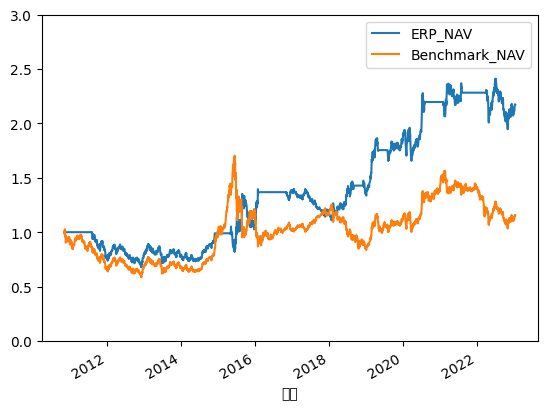

In [6]:
# ERP 信号
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

data = pd.read_excel('ERP股债性价比指标.xlsx')
data['日期'] = pd.to_datetime(data['日期'])

# 筛选从2010-01-12开始的数据
start_date = pd.to_datetime('2010-10-30')
filtered_data = data[data['日期'] >= start_date]

filtered_data.set_index('日期', inplace=True)

# 计算加权ERP分位数的指数加权移动平均
window = 120
erp_percentile = filtered_data['ERP五年滚动百分位']
weights = np.arange(1, window + 1)
weighted_erp_percentile = erp_percentile.rolling(window).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

def generate_signal(weighted_erp_percentile):
    signal = np.where(weighted_erp_percentile > 0.7, 1, np.where(weighted_erp_percentile < 0.3, -1, 0))
    return signal
    
# 生成信号
signal = generate_signal(weighted_erp_percentile)

filtered_data["weighted_erp_percentile"] = weighted_erp_percentile
filtered_data["ERP_Signal"] = signal

last_day_signals = filtered_data['ERP_Signal'].resample('M').last()

# 找出每个月的最后一天索引，并将下一个月的第一天的索引替换为下一个月的最后一天的索引
next_month_first_day_index = last_day_signals.index + pd.offsets.MonthBegin(1)
last_day_signals.index = next_month_first_day_index - pd.offsets.Day(1)

# 将最后一天的信号向前填充应用到下一个月除了最后一天的所有日期上
monthly_signals = filtered_data['ERP_Signal'].copy()
monthly_signals[:-1] = last_day_signals.reindex(monthly_signals[:-1].index, method='ffill').values.astype(int)

# 将月频信号添加到MA_data中
filtered_data['ERP 月度信号'] = monthly_signals

filtered_data['pos'] = filtered_data['ERP 月度信号'].shift()

filtered_data['benchmark_return'] = filtered_data['000906.SH'].pct_change()

filtered_data['ERP_return'] = filtered_data['benchmark_return'] * filtered_data['pos']

filtered_data['ERP_nvm'] = 1

filtered_data['ERP_nvm'] = (1 + filtered_data['ERP_return']).cumprod()

filtered_data['benchmark_nvm'] = 1

filtered_data['benchmark_nvm'] = (1 + filtered_data['benchmark_return']).cumprod()

filtered_data['ERP_nvm'].plot()
filtered_data['benchmark_nvm'].plot()
plt.ylim([0,3])

plt.legend(['ERP_NAV','Benchmark_NAV'])

(0.0, 3.5)

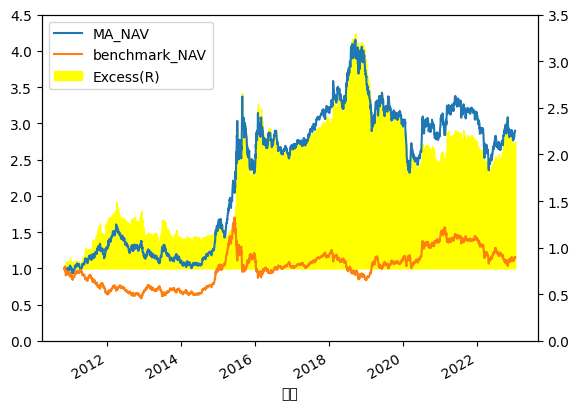

In [7]:
# MA信号 单独的股票 MA 信号
# 生成信号

selected_columns = ['000906.SH', 'MA 均线', 'benchmark_return', 'benchmark_nvm']  # 替换为你的需要的列名
# MA_data = filtered_data[selected_columns].copy()
MA_data = filtered_data.copy()

MA_data['MA_Signal'] = 0
MA_data.loc[MA_data['000906.SH'] > MA_data['MA 均线'], 'MA_Signal'] = 1
MA_data.loc[MA_data['000906.SH'] < MA_data['MA 均线'], 'MA_Signal'] = -1

last_day_signals = MA_data['MA_Signal'].resample('M').last()

# 找出每个月的最后一天索引，并将下一个月的第一天的索引替换为下一个月的最后一天的索引
next_month_first_day_index = last_day_signals.index + pd.offsets.MonthBegin(1)
last_day_signals.index = next_month_first_day_index - pd.offsets.Day(1)

# 将最后一天的信号向前填充应用到下一个月除了最后一天的所有日期上
monthly_signals = MA_data['MA_Signal'].copy()
monthly_signals[:-1] = last_day_signals.reindex(monthly_signals[:-1].index, method='ffill').values.astype(int)

# 将月频信号添加到MA_data中
MA_data['MA 月度信号'] = monthly_signals

MA_data['pos'] = MA_data['MA 月度信号'].shift()

MA_data['strategy_return'] = MA_data['benchmark_return'] * MA_data['pos']

MA_data['strategy_nvm'] = 1

MA_data['strategy_nvm'] = (1 + MA_data['strategy_return']).cumprod()

pd.set_option('display.max_rows', None)
MA_data['strategy_nvm'].plot()
filtered_data['benchmark_nvm'].plot()

excess_data = MA_data['strategy_nvm'] - filtered_data['benchmark_nvm'] + 1
plt.fill_between(excess_data.index, 1, excess_data, color='yellow')
plt.ylim([0,4.5])
plt.legend(['MA_NAV','benchmark_NAV', 'Excess(R)'])

ax2 = plt.twinx()
ax2.set_ylim([0,3.5])

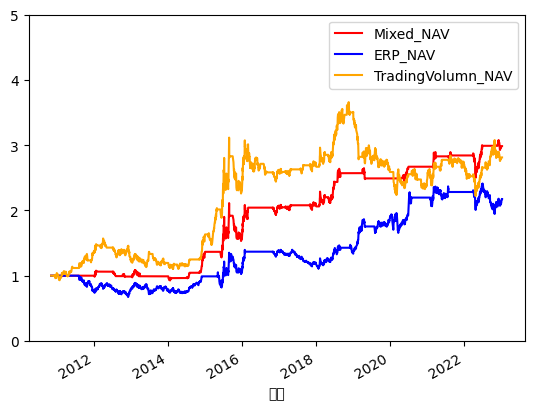

In [8]:
# 单独的成交量信号 m = 5
# 生成信号
selected_columns = ['MA_Signal','ERP_Signal', '000906.SH', '成交量均线', '000906.SH成交量', 'benchmark_return', 'benchmark_nvm', 'ERP 月度信号']
# Mixed_data = MA_data[selected_columns].copy()
Mixed_data = MA_data

Mixed_data['Turnover_Signal'] = 0
Mixed_data.loc[Mixed_data['MA_Signal'] == -1, 'Turnover_Signal'] = -1
Mixed_data.loc[(Mixed_data['MA_Signal'] == 1) & (Mixed_data['000906.SH成交量'] > Mixed_data['成交量均线']), 'Turnover_Signal'] = 1

Mixed_data['Mixed_Signal'] = 0
Mixed_data.loc[(Mixed_data['Turnover_Signal'] == 1) & (Mixed_data['ERP 月度信号'] == 1), 'Mixed_Signal'] = 1
Mixed_data.loc[(Mixed_data['Turnover_Signal'] == -1) & (Mixed_data['ERP 月度信号'] == -1), 'Mixed_Signal'] = -1

# ===================Turnover monthly signal
last_day_signals = Mixed_data['Turnover_Signal'].resample('M').last()
# 找出每个月的最后一天索引，并将下一个月的第一天的索引替换为下一个月的最后一天的索引
next_month_first_day_index = last_day_signals.index + pd.offsets.MonthBegin(1)
last_day_signals.index = next_month_first_day_index - pd.offsets.Day(1)
# 将最后一天的信号向前填充应用到下一个月除了最后一天的所有日期上
monthly_signals = Mixed_data['Turnover_Signal'].copy()
monthly_signals[:-1] = last_day_signals.reindex(monthly_signals[:-1].index, method='ffill').values.astype(int)
# 将月频信号添加到MA_data中
Mixed_data['成交量 月度信号'] = monthly_signals
Mixed_data['pos'] = Mixed_data['成交量 月度信号'].shift()

Mixed_data['成交量_return'] = Mixed_data['benchmark_return'] * Mixed_data['pos']
Mixed_data['成交量_nvm'] = 1
Mixed_data['成交量_nvm'] = (1 + Mixed_data['成交量_return']).cumprod()

# ===================Mixed monthly signal (MA + Turnover +  ERP)
last_day_signals = Mixed_data['Mixed_Signal'].resample('M').last()
# 找出每个月的最后一天索引，并将下一个月的第一天的索引替换为下一个月的最后一天的索引
next_month_first_day_index = last_day_signals.index + pd.offsets.MonthBegin(1)
last_day_signals.index = next_month_first_day_index - pd.offsets.Day(1)
# 将最后一天的信号向前填充应用到下一个月除了最后一天的所有日期上
monthly_signals = Mixed_data['Mixed_Signal'].copy()
monthly_signals[:-1] = last_day_signals.reindex(monthly_signals[:-1].index, method='ffill').values.astype(int)
# 将月频信号添加到MA_data中
Mixed_data['合成 月度信号'] = monthly_signals
Mixed_data['pos'] = Mixed_data['合成 月度信号'].shift()

Mixed_data['合成_return'] = Mixed_data['benchmark_return'] * Mixed_data['pos']
Mixed_data['合成_nvm'] = 1
Mixed_data['合成_nvm'] = (1 + Mixed_data['合成_return']).cumprod()

Mixed_data['合成_nvm'].plot(color = 'red')
filtered_data['ERP_nvm'].plot(color = 'blue')
Mixed_data['成交量_nvm'].plot(color = 'orange')

plt.ylim([0,5])
plt.legend(['Mixed_NAV','ERP_NAV','TradingVolumn_NAV'])

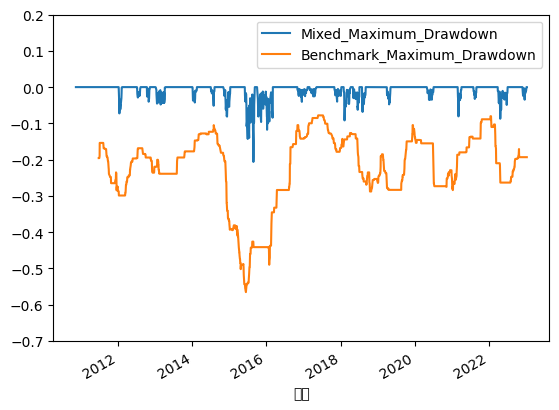

In [10]:
# 合成指标回撤
# 合成 净值 五日滚动最高点
Mixed_data['Highest_nvm'] = Mixed_data['合成_nvm'].rolling(window = 5).max()
# 合成 净值 五日滚动最低点
Mixed_data['Lowest_nvm'] = Mixed_data['合成_nvm'].rolling(window = 5).min()
# 最大回撤 = （最高点 - 最低点）/最高点
Mixed_data['Max_drawdown'] = (Mixed_data['Lowest_nvm'] - Mixed_data['Highest_nvm'])/Mixed_data['Highest_nvm']
Mixed_data['Max_drawdown'].plot()

# Benchmark回撤
# 中证800 净值 五日滚动最高点
Mixed_data['Highest_benchmark'] = Mixed_data['benchmark_nvm'].rolling(window = 156).max()
# 中证800 净值 五日滚动最低点
Mixed_data['Lowest_benchmark'] = Mixed_data['benchmark_nvm'].rolling(window = 156).min()
# 最大回撤 = （最高点 - 最低点）/最高点
Mixed_data['Max_drawdown_B'] = (Mixed_data['Lowest_benchmark'] - Mixed_data['Highest_benchmark'])/Mixed_data['Highest_benchmark']
Mixed_data['Max_drawdown_B'].plot()

plt.ylim([-0.7,0.2])
plt.legend(['Mixed_Maximum_Drawdown', 'Benchmark_Maximum_Drawdown'])


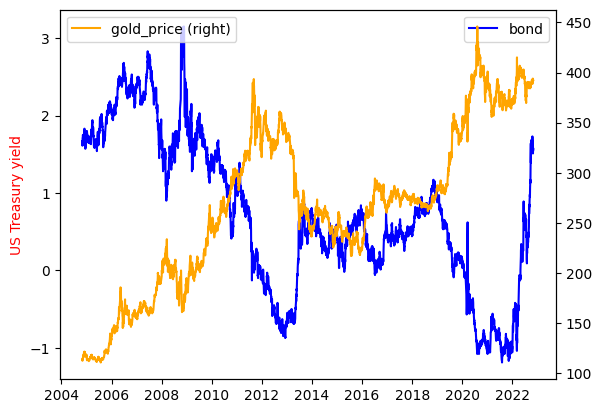

In [11]:
# 黄金择时指标

gold_data = pd.read_excel('黄金择时.xlsx')

# gold_data['美债收益率'] = pd.to_numeric(gold_data['美债收益率'], errors='coerce')
# gold_data['美债收益率'].replace(0.00, np.nan, inplace=True)
# gold_data['Au9999'] = pd.to_numeric(gold_data['Au9999'], errors='coerce')
# gold_data['Au9999'].replace(0.00, np.nan, inplace=True)

gold_data['日期'] = pd.to_datetime(gold_data['日期'])

gold_data.set_index('日期', inplace= True)
pd.set_option('display.max_rows', None)


fig, ax2 = plt.subplots()

ax2.plot(gold_data.index, gold_data['美债收益率'], color='blue')
ax2.set_ylabel('US Treasury yield', color='red')

ax1 = ax2.twinx()
ax1.plot(gold_data.index, gold_data['Au9999'], color='orange')

ax1.legend(['gold_price (right)'])
ax2.legend(['bond'])



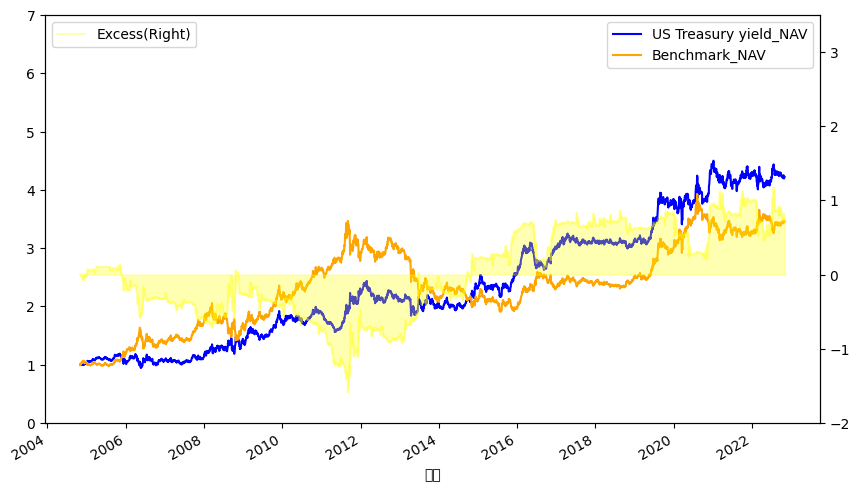

In [12]:
# 生成信号
gold_data['MA_Signal'] = 0
gold_data.loc[gold_data['美债收益率'] > gold_data['美债收益率MA'], 'MA_Signal'] = -1
gold_data.loc[gold_data['美债收益率'] < gold_data['美债收益率MA'], 'MA_Signal'] = 1

last_day_signals = gold_data['MA_Signal'].resample('M').last()
# 找出每个月的最后一天索引，并将下一个月的第一天的索引替换为下一个月的最后一天的索引
next_month_first_day_index = last_day_signals.index + pd.offsets.MonthBegin(1)
last_day_signals.index = next_month_first_day_index - pd.offsets.Day(1)

# 将最后一天的信号向前填充应用到下一个月除了最后一天的所有日期上
monthly_signals = gold_data['MA_Signal'].copy()
monthly_signals[:-1] = last_day_signals.reindex(monthly_signals[:-1].index, method='ffill').values.astype(int)

# 将月频信号添加到MA_data中
gold_data['MA 月度信号'] = monthly_signals

gold_data['benchmark_return'] = gold_data['Au9999'].pct_change()

gold_data['pos'] = gold_data['MA 月度信号'].shift()

gold_data['strategy_return'] = gold_data['benchmark_return'] * gold_data['pos']

gold_data['strategy_nvm'] = 1

gold_data['strategy_nvm'] = (1 + gold_data['strategy_return']).cumprod()

gold_data['benchmark_nvm'] = 1

gold_data['benchmark_nvm'] = (1 + gold_data['benchmark_return']).cumprod()

plt.subplots(figsize=(10, 6))

gold_data['strategy_nvm'].plot(color='blue')
gold_data['benchmark_nvm'].plot(color='orange')
plt.legend(['US Treasury yield_NAV', 'Benchmark_NAV'])

plt.ylim([0, 7])


ax2 = plt.twinx()
ax2.set_ylim([-2, 3.5])

excess_data = gold_data['strategy_nvm'] - gold_data['benchmark_nvm']

plt.plot(excess_data.index, excess_data, color='yellow', alpha=0.3)
plt.fill_between(excess_data.index, 0, excess_data, color='yellow', alpha=0.3) 
plt.legend(['Excess(Right)'], loc='upper left')



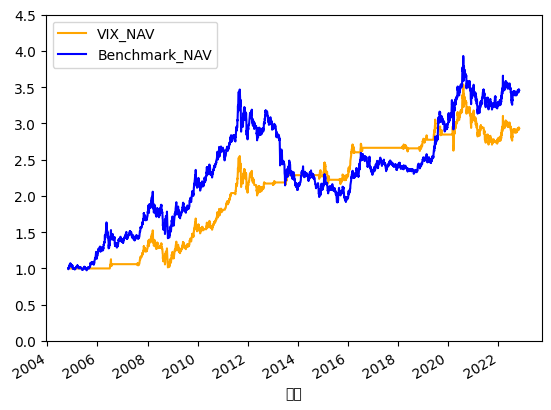

In [13]:
gold_data['VIX_signal'] = 0
gold_data.loc[gold_data['VIX(15Max)'] > 20, 'VIX_signal'] = 1

last_day_signals = gold_data['VIX_signal'].resample('M').last()
# 找出每个月的最后一天索引，并将下一个月的第一天的索引替换为下一个月的最后一天的索引
next_month_first_day_index = last_day_signals.index + pd.offsets.MonthBegin(1)
last_day_signals.index = next_month_first_day_index - pd.offsets.Day(1)

# 将最后一天的信号向前填充应用到下一个月除了最后一天的所有日期上
monthly_signals = gold_data['VIX_signal'].copy()
monthly_signals[:-1] = last_day_signals.reindex(monthly_signals[:-1].index, method='ffill').values.astype(int)

# 将月频信号添加到MA_data中
gold_data['vix 月度信号'] = monthly_signals

gold_data['vix_return'] = gold_data['VIX'].pct_change()

gold_data['pos'] = gold_data['vix 月度信号'].shift()

gold_data['strategy_return'] = gold_data['benchmark_return'] * gold_data['pos']

gold_data['strategy_nvm'] = 1

gold_data['strategy_nvm'] = (1 + gold_data['strategy_return']).cumprod()

gold_data['vix_nvm'] = 1

gold_data['vix_nvm'] = (1 + gold_data['vix_return']).cumprod()

gold_data['strategy_nvm'].plot(color = 'orange')
gold_data['benchmark_nvm'].plot(color = 'blue')
plt.ylim([0,4.5])
plt.legend(['VIX_NAV','Benchmark_NAV'])


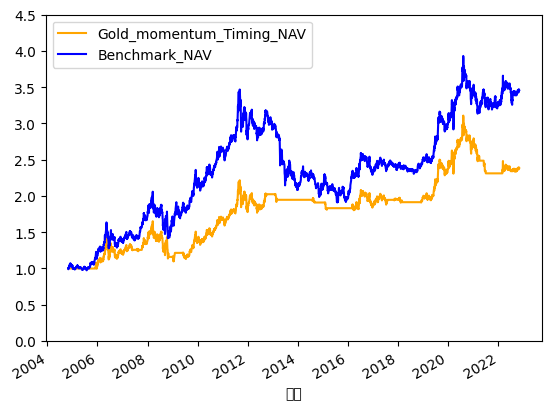

In [14]:
gold_data['AU9999_signal'] = 0
gold_data.loc[gold_data['Au9999(250)'] > 0, 'AU9999_signal'] = 1

last_day_signals = gold_data['AU9999_signal'].resample('M').last()
# 找出每个月的最后一天索引，并将下一个月的第一天的索引替换为下一个月的最后一天的索引
next_month_first_day_index = last_day_signals.index + pd.offsets.MonthBegin(1)
last_day_signals.index = next_month_first_day_index - pd.offsets.Day(1)

# 将最后一天的信号向前填充应用到下一个月除了最后一天的所有日期上
monthly_signals = gold_data['AU9999_signal'].copy()
monthly_signals[:-1] = last_day_signals.reindex(monthly_signals[:-1].index, method='ffill').values.astype(int)

# 将月频信号添加到MA_data中
gold_data['AU9999 月度信号'] = monthly_signals

gold_data['AU9999_return'] = gold_data['Au9999'].pct_change()

gold_data['pos'] = gold_data['AU9999 月度信号'].shift()

gold_data['strategy_return'] = gold_data['AU9999_return'] * gold_data['pos']

gold_data['strategy_nvm'] = 1

gold_data['strategy_nvm'] = (1 + gold_data['strategy_return']).cumprod()

gold_data['AU9999_nvm'] = 1

gold_data['AU9999_nvm'] = (1 + gold_data['AU9999_return']).cumprod()

gold_data['strategy_nvm'].plot(color = 'orange')
gold_data['AU9999_nvm'].plot(color = 'blue')
plt.ylim([0,4.5])
plt.legend(['Gold_momentum_Timing_NAV', 'Benchmark_NAV'])